In [1]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#from torchvision.models.detection import (
#    fasterrcnn_resnet50_fpn, 
#    FasterRCNN_ResNet50_FPN_Weights
#    )
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import cv2
from torchvision.transforms import functional as F
import numpy as np

In [2]:
def load_model(checkpoint_path, num_classes=4):
#def load_model(checkpoint_path, num_classes=3):
    # 1. Инициализация модели с предобученными весами backbone
    #weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
    #model = fasterrcnn_resnet50_fpn(weights=weights)
    weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
    model = fasterrcnn_resnet50_fpn_v2(weights=weights)
    
    # 2. Замена box_predictor для своего числа классов
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # 3. Загрузка checkpoint
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    
    # 4. Извлекаем только веса модели (игнорируем optimizer и epoch)
    if 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
    else:
        state_dict = checkpoint
    
    # 5. Аккуратная загрузка весов
    model.load_state_dict(state_dict, strict=False)  # strict=False пропустит отсутствующие ключи
    
    # 6. Перевод в режим оценки
    model.eval()
    
    return model

In [3]:
model = load_model(
    checkpoint_path='/home/lastinm/PROJECTS/credit_cards_detection/train/Faster R-CNN/exp/summary/02-05-2025-15-46-48/best_model.pth',
    #checkpoint_path='/home/lastinm/PROJECTS/CV/experiments/FasterRCNN-Torchvision-FineTuning/exp/summary/02-04-2025-21-19-48/best_model.pth',
    #checkpoint_path='/home/lastinm/PROJECTS/CV/experiments/FasterRCNN-Torchvision-FineTuning-v2/exp/summary/04-04-2025-23-09-41/best_model.pth',
    #checkpoint_path='/home/lastinm/PROJECTS/CV/experiments/FasterRCNN-Torchvision-FineTuning-v2/exp/summary/09-04-2025-06-15-03/best_model.pth',
    num_classes=4  # Укажите реальное число ваших классов (3 класса + фон)
    #num_classes=3  # Укажите реальное число ваших классов (версия 2: 3 класса без фона)
    )

In [4]:
def detect_objects(model, image_path, confidence_threshold=0.7):
    """
    Детекция объектов на изображении с помощью загруженной модели
    Args:
        model: Загруженная модель Faster R-CNN
        image_path: Путь к изображению
        confidence_threshold: Порог уверенности для отображения (0.0-1.0)
    Returns:
        Словарь с результатами детекции
    """
    # 1. Загрузка и преобразование изображения
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV -> RGB
    image_tensor = F.to_tensor(image)  # Конвертация в тензор [0-1]

    # 2. Добавление batch dimension и перемещение на устройство (GPU/CPU)
    image_tensor = image_tensor.unsqueeze(0).to(next(model.parameters()).device)
    
    # 3. Запуск модели (без вычисления градиентов)
    with torch.no_grad():
        predictions = model(image_tensor)
    
    # 4. Фильтрация результатов по порогу уверенности
    pred_boxes = predictions[0]['boxes'].cpu().numpy()
    pred_scores = predictions[0]['scores'].cpu().numpy()
    pred_classes = predictions[0]['labels'].cpu().numpy()
    
    keep = pred_scores >= confidence_threshold
    results = {
        'boxes': pred_boxes[keep],
        'scores': pred_scores[keep],
        'classes': pred_classes[keep]
    }
    
    return results

In [5]:
def visualize_results_matplotlib(image_path, results, class_names):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)
    
    colors = ['red', 'green', 'blue', 'yellow', 'purple']
    
    for box, score, cls in zip(results['boxes'], results['scores'], results['classes']):
        x1, y1, x2, y2 = map(int, box)
        rect = patches.Rectangle(
            (x1, y1), x2-x1, y2-y1,
            linewidth=2, edgecolor=colors[cls % len(colors)], facecolor='none'
        )
        ax.add_patch(rect)
        
        plt.text(
            x1, y1-10, f"{class_names[cls]}: {score:.2f}",
            color=colors[cls % len(colors)], fontsize=10,
            bbox=dict(facecolor='white', alpha=0.8)
        )
    
    plt.axis('off')
    plt.show()

In [6]:
# СБЕР
image_path = '/home/lastinm/PROJECTS/credit_cards_detection/dataset/coco/test/1742460932042_resized_jpg.rf.cc580bf6003a8859a97b0c846b08415c.jpg'
# Авангард
#image_path = '/home/lastinm/PROJECTS/credit_cards_detection/dataset/ocr val/1742460932124_resized_jpg.rf.ae82439353cb014cd13031eaed480be1.jpg'

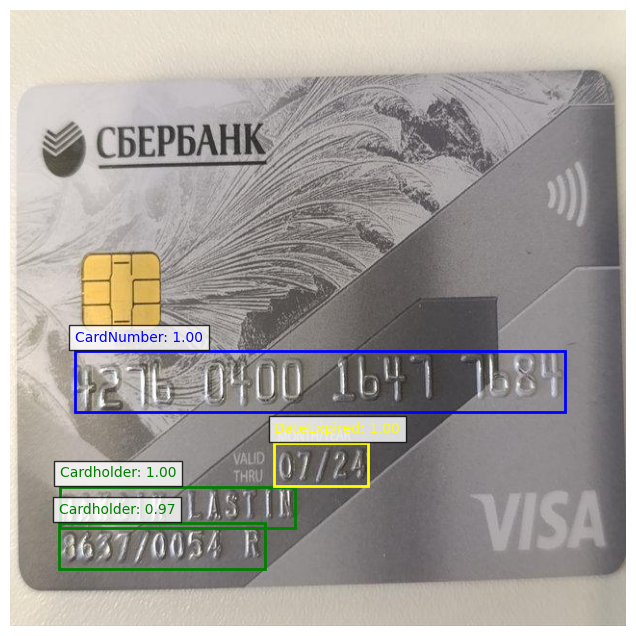

Найдено объектов: 4
Объект 1: Cardholder (уверенность: 1.00)
Координаты: x1=51.3, y1=495.3, x2=296.0, y2=538.5
Объект 2: CardNumber (уверенность: 1.00)
Координаты: x1=67.7, y1=354.8, x2=576.3, y2=417.7
Объект 3: DateExpired (уверенность: 1.00)
Координаты: x1=275.0, y1=449.9, x2=371.3, y2=494.7
Объект 4: Cardholder (уверенность: 0.97)
Координаты: x1=50.7, y1=533.0, x2=264.2, y2=580.2


In [7]:
# 1. Детекция на изображении
results = detect_objects(
    model=model,
    image_path=image_path,
    confidence_threshold=0.5  # Можно регулировать
    )
    
# 2. Визуализация
class_names = ["Background", "Cardholder", "CardNumber", "DateExpired"]  # Пример
visualize_results_matplotlib(image_path, results, class_names)
    
# 3. Вывод результатов в консоль
print(f"Найдено объектов: {len(results['boxes'])}")
for i, (box, score, cls) in enumerate(zip(results['boxes'], results['scores'], results['classes'])):
    print(f"Объект {i+1}: {class_names[cls]} (уверенность: {score:.2f})")
    print(f"Координаты: x1={box[0]:.1f}, y1={box[1]:.1f}, x2={box[2]:.1f}, y2={box[3]:.1f}")

In [8]:
import os
import shutil

In [9]:
def prepare_output_dir(output_dir):
    """Более простая версия с полным удалением папки"""
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)

In [10]:
def save_and_display_bboxes(image_path, results, output_dir='output', confidence_threshold=0.5):
    """
    Сохраняет и отображает изображения с bounding boxes
    
    Args:
        image_path: путь к исходному изображению
        results: результаты детекции (словарь с 'boxes', 'scores', 'classes')
        output_dir: директория для сохранения результатов
        confidence_threshold: порог уверенности для отображения
    """
    # Создаем директорию для результатов
    prepare_output_dir(output_dir)
    
    # Загружаем изображение
    # Преобразование PIL.Image в numpy array
    # if isinstance(image, Image.Image):
    #     image = np.array(image)

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #image_with_boxes = image.copy()
    
    # Получаем данные из результатов
    boxes = results['boxes']
    scores = results['scores']
    classes = results['classes']

    # Получаем базовое имя файла без расширения
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    ext = os.path.splitext(image_path)[1]
       
    # Сохраняем каждую обнаруженную область отдельно
    for i, (box, score, cls) in enumerate(zip(boxes, scores, classes)):
        if score >= confidence_threshold:
            x1, y1, x2, y2 = map(int, box)
            cropped = image[y1:y2, x1:x2]
            
            if cropped.size > 0:  # Проверяем, что область не пустая
                # Формируем имя файла с классом в начале
                crop_path = os.path.join(output_dir, f'{cls}_{base_name}_crop{i}{ext}')
                Image.fromarray(cropped).save(crop_path)
                
                # Выводим обрезанные области
                plt.figure(figsize=(6, 4))
                plt.imshow(cropped)
                plt.title(f"Class {cls}, Score: {score:.2f}")
                plt.axis('off')
                plt.show()

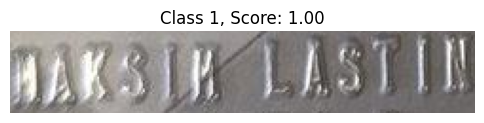

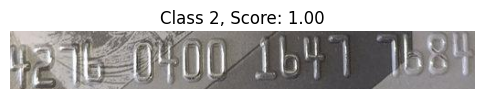

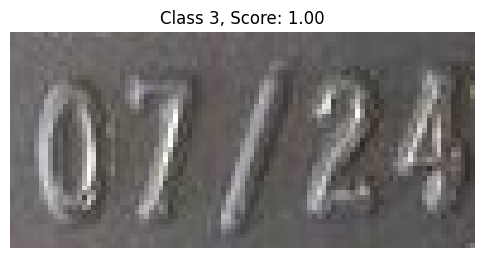

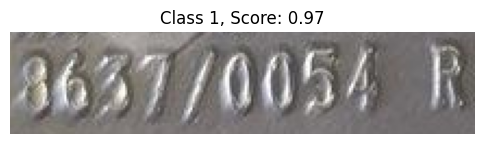

In [11]:
# Сохраняем и отображаем результаты
save_and_display_bboxes(image_path, results, confidence_threshold=0.7)

# Распознавание TrOCR

In [12]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from transformers import (TrOCRProcessor, 
                          VisionEncoderDecoderModel)
import torch
import cv2
import numpy as np

/home/lastinm/PROJECTS/credit_cards_detection/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-10 12:17:04.533733: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-10 12:17:05.182817: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-10 12:17:05.182842: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered

In [13]:
# 1. Загрузка модели и процессора
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transfor

In [15]:
def visualize_enhanced_results_one_img(orig_path, confidences, class_id, processed_img, full_text):
    """Визуализация обработанного изображения"""
    # Создаем фигуру только для обработанного изображения
    plt.figure(figsize=(12, 8))
    
    # Преобразование PIL.Image в numpy array
    if isinstance(processed_img, Image.Image):
        processed_img_array = np.array(processed_img)
    # Отображаем обработанное изображение
    plt.imshow(processed_img_array, cmap='gray')
    plt.title(f"Результаты распознавания (Класс {class_id})", fontsize=32)
    
    plt.axis('off')  # Скрываем оси
    plt.tight_layout()
    plt.show()

    # Вывод результатов
    print(f"Распознанный текст: '{full_text}'")
    print("Соответствие символов и уверенностей:")
    for char, conf in zip(full_text, confidences):
        print(f"'{char}': {conf:.1%}")

In [16]:
# Извлечение уверенности
def get_text_with_confidence(outputs):
        
    # Получаем все токены (игнорируя <s> и </s>)
    tokens = outputs.sequences[0][1:-1]
    
    # Собираем результаты
    result_text = []
    confidences = []
    
    # Обрабатываем каждый токен
    for i, token in enumerate(tokens):
        # Получаем текстовое представление токена
        token_text = processor.decode([token], skip_special_tokens=True)
        
        # Получаем уверенность для этого токена
        confidence = torch.softmax(outputs.scores[i], dim=-1)[0, token].item()
        
        # Для каждого символа в декодированном токене добавляем уверенность
        for char in token_text:
            result_text.append(char)
            confidences.append(confidence)
    
    # Собираем полный текст
    full_text = ''.join(result_text)
        
    return full_text, confidences

In [17]:
def recognize_images_in_directory(directory, languages=['en', 'ru'], gpu=False):
    """
    Распознает текст на изображениях с учетом класса из имени файла
    
    Args:
        directory: путь к директории с изображениями
        languages: список языков для распознавания
        gpu: использовать ли GPU
    """ 

    # Получаем список файлов
    image_files = [f for f in os.listdir(directory) 
                 if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
    
    if not image_files:
        print(f"В директории {directory} не найдено изображений")
        return
    
    print(f"Найдено {len(image_files)} изображений для распознавания...")
    
    # Обрабатываем каждое изображение
    for img_file in image_files:
        img_path = os.path.join(directory, img_file)
        print(f"\nОбработка файла: {img_file}")
        
        try:
            # Извлекаем класс из имени файла (первый символ перед '_')
            class_id = img_file.split('_')[0]
            
            # Загрузка и предобработка изображения
            image = Image.open(img_path).convert("RGB")
            # # Увеличим маленький текст:
            # # Получаем текущие размеры
            # width, height = image.size

            # # Вычисляем новые размеры (увеличиваем ширину в 1.5 раза)
            # new_width = int(width * 1.5)
            # new_height = int(height * (new_width / width))  # Сохраняем пропорции

            # Масштабируем изображение
            # resized_image = image.resize((new_width, new_height), Image.Resampling.LANCZOS)
            # уберем фон
            #image = remove_background_simple(img_path)
            #image = remove_background_adaptive(img_path)
            pixel_values = processor(image, return_tensors="pt").pixel_values   
            
            # Генерация текста
            outputs = model.generate(
                pixel_values,
                output_scores=True,
                return_dict_in_generate=True,
                max_length=50
            )

            # Результат
            full_text, confidences = get_text_with_confidence(outputs)
            
            # Визуализация с указанием класса
            visualize_enhanced_results_one_img(img_path, confidences, class_id, image, full_text)

        except Exception as e:
            print(f"Ошибка при обработке файла {img_file}: {str(e)}")

Найдено 4 изображений для распознавания...

Обработка файла: 1_1742460932042_resized_jpg.rf.cc580bf6003a8859a97b0c846b08415c_crop0.jpg


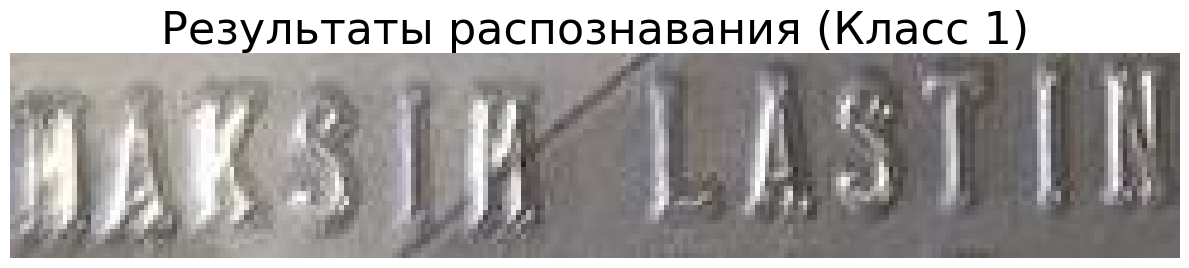

Распознанный текст: 'MAK3LN LASTIN'
Соответствие символов и уверенностей:
'M': 72.7%
'A': 72.7%
'K': 88.9%
'3': 87.7%
'L': 47.6%
'N': 58.4%
' ': 57.2%
'L': 57.2%
'A': 57.2%
'S': 57.2%
'T': 57.2%
'I': 98.0%
'N': 98.0%

Обработка файла: 2_1742460932042_resized_jpg.rf.cc580bf6003a8859a97b0c846b08415c_crop1.jpg


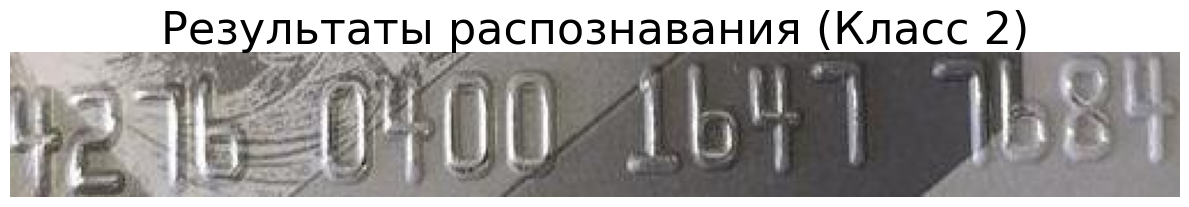

Распознанный текст: '12 15-0400 1641 1884'
Соответствие символов и уверенностей:
'1': 23.4%
'2': 23.4%
' ': 29.5%
'1': 29.5%
'5': 29.5%
'-': 76.2%
'0': 98.7%
'4': 98.7%
'0': 100.0%
'0': 100.0%
' ': 48.9%
'1': 48.9%
'6': 48.9%
'4': 63.9%
'1': 63.9%
' ': 30.5%
'1': 30.5%
'8': 30.5%
'8': 99.9%
'4': 99.9%

Обработка файла: 3_1742460932042_resized_jpg.rf.cc580bf6003a8859a97b0c846b08415c_crop2.jpg


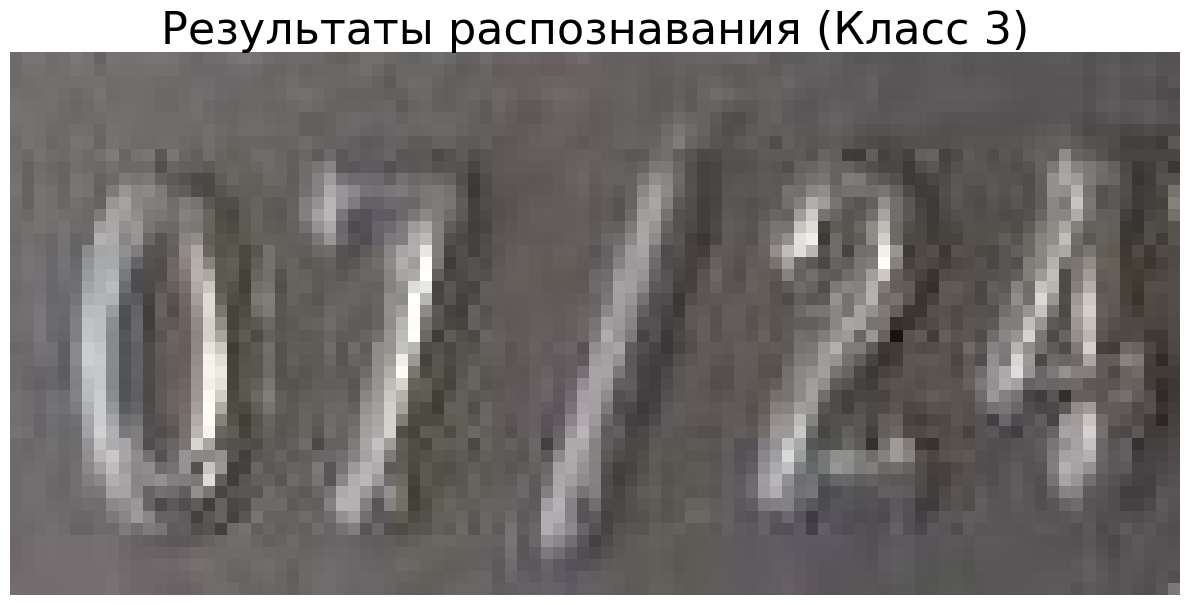

Распознанный текст: '07/24'
Соответствие символов и уверенностей:
'0': 99.6%
'7': 99.6%
'/': 99.3%
'2': 99.9%
'4': 99.9%

Обработка файла: 1_1742460932042_resized_jpg.rf.cc580bf6003a8859a97b0c846b08415c_crop3.jpg


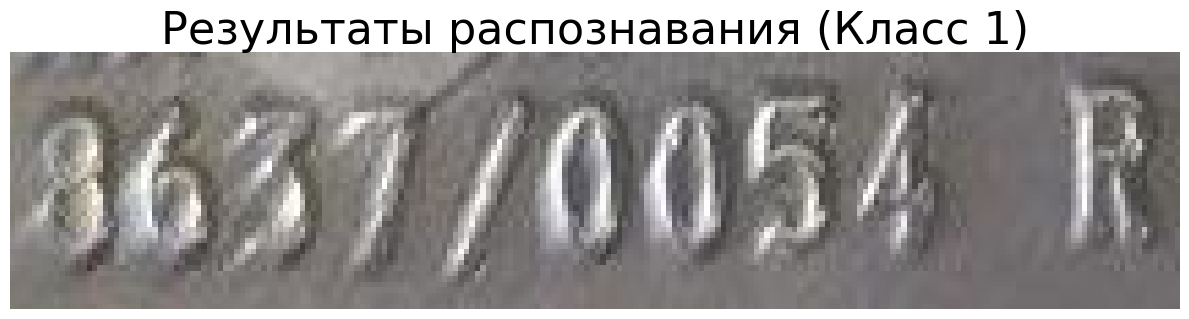

Распознанный текст: '863770054 R'
Соответствие символов и уверенностей:
'8': 94.2%
'6': 94.2%
'3': 99.6%
'7': 99.6%
'7': 65.5%
'0': 65.5%
'0': 65.5%
'5': 100.0%
'4': 100.0%
' ': 99.6%
'R': 99.6%


In [18]:
output_dir = 'output'  # директория с изображениями
recognize_images_in_directory(output_dir, languages=['en'], gpu=False)